In [1]:
import numpy as np
import ffmpeg
import matplotlib.pyplot as plt
from numpy import linalg as LA
import argparse
import threading
import sounddevice as sd
import soundfile as sf
from numpy.fft import fft, ifft
from random import seed
from random import gauss
from scipy import signal
from scipy.signal import butter, freqz, hilbert
from pydub import AudioSegment

C:\Users\Privat\AppData\Local\Programs\Python\Python311\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
plt.rcParams.update({'font.size': 24})
plt.rcParams["figure.dpi"] = 200
plt.rcParams['figure.figsize'] = [15,7]
plt.rcParams['lines.linewidth'] = 0.8

In [3]:
sr1=21000

def record_sound(file_path, duration, sr=sr1, channels=1, dtype='int32'):
    print("goooo")
    record = sd.rec(int(sr * duration), samplerate=sr, channels=channels, dtype=dtype)
    sd.wait()
    print("stop")
    sf.write(file_path, record, sr)
record_sound("sound.wav",3)

goooo
stop


sound_good.wav
[ 0.00000000e+00  3.05175781e-05  0.00000000e+00 ... -3.05175781e-05
 -6.10351562e-05 -6.10351562e-05]


<function matplotlib.pyplot.show(close=None, block=None)>

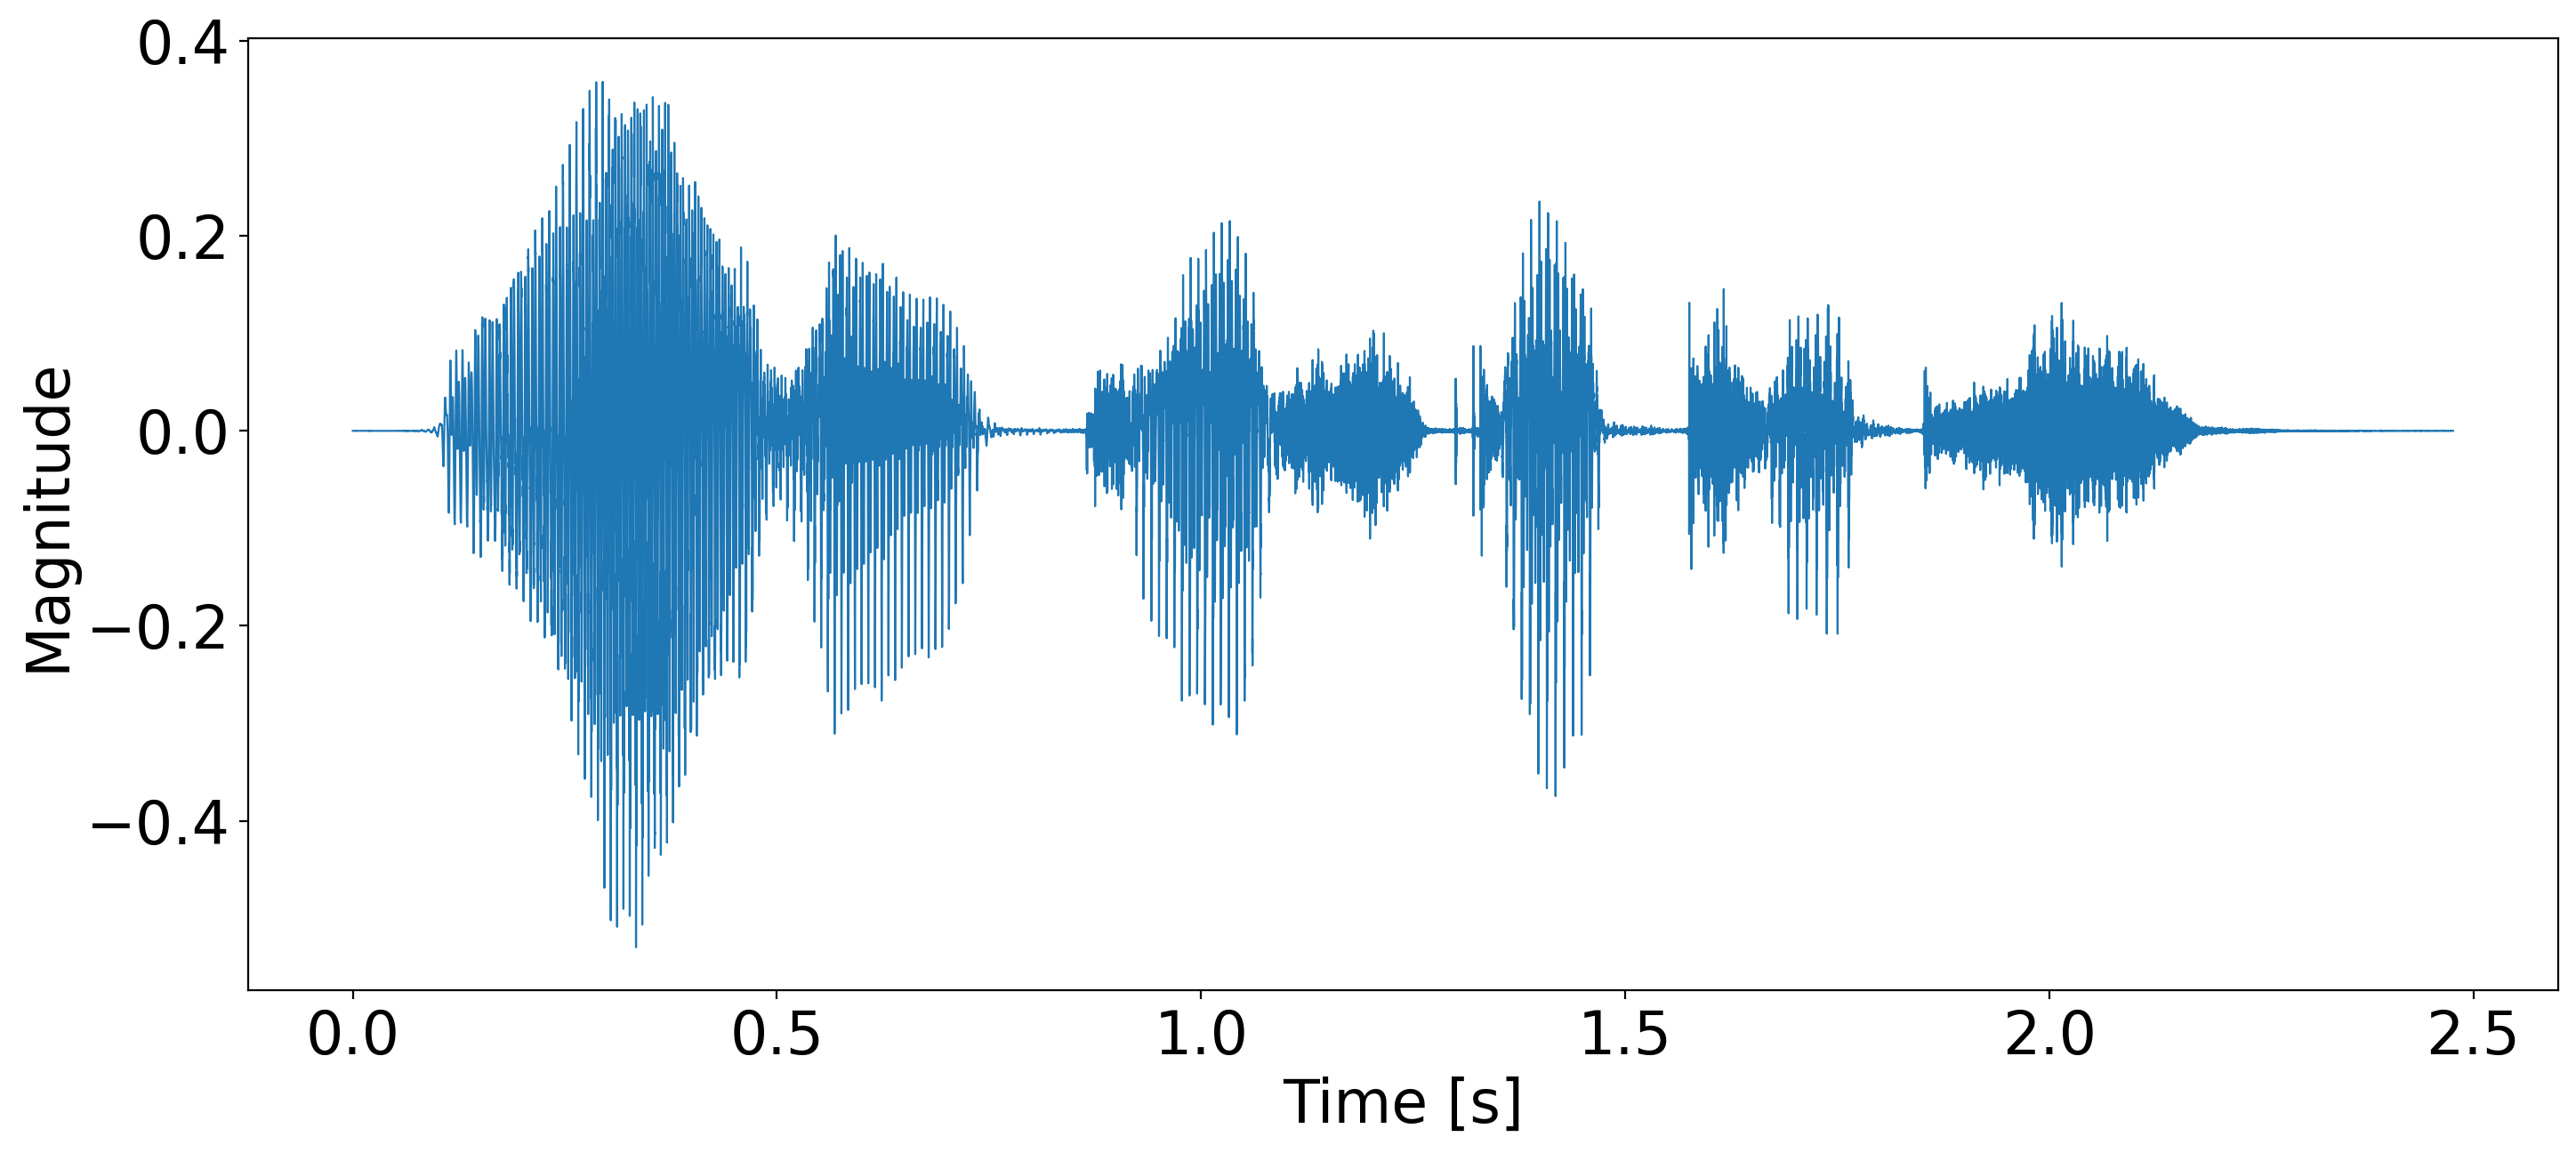

In [4]:
record = "sound_good.wav"
print(record)
def play_sound(filename, final="no"):   
    if isinstance(filename, np.ndarray):
        if final=="final":
            sf.write("Vocoder_final.wav", filename, sr1)
            data, samplerate = sf.read("Vocoder_final.wav")
        else:
            sf.write("temp_sound.wav", filename, sr1)
            data, samplerate = sf.read("temp_sound.wav")
        sd.play(data, samplerate)
        sd.wait()

    elif filename.endswith('.wav'):
        data, samplerate = sf.read(filename)
        sd.play(data, samplerate)
        sd.wait()

    else: 
        print("wrong file")
    return data
    
sound1_pure= play_sound(record)
sound1 = sound1_pure[11000:]
print(sound1)

t=np.arange(0,len(sound1),1)
plt.plot(t/sr1,sound1)
plt.xlabel('Time [s]')
plt.ylabel('Magnitude')
#plt.savefig("Magnitude.pdf")
plt.tight_layout()
plt.show


In [5]:
# def thresholdfilter(sound,thr):
#     filtered_sound=[]
#     for i in sound:
#         #print(i)
#         if np.abs(i) <= thr:
#             filtered_sound.append(0)
#         else:
#             filtered_sound.append(i)
#     return filtered_sound
# sound1=thresholdfilter(sound1,0.01)
# sf.write("Dominik_filtered.wav", sound1, sr1)
# play_sound("Dominik_filtered.wav")
# plt.plot(t,sound1)

In [6]:
def generate_noise():
    noise=[]
    for i in range(len(t)):
        noise_i = gauss(0, 1)
        noise.append(noise_i)
    return noise
noise=generate_noise()

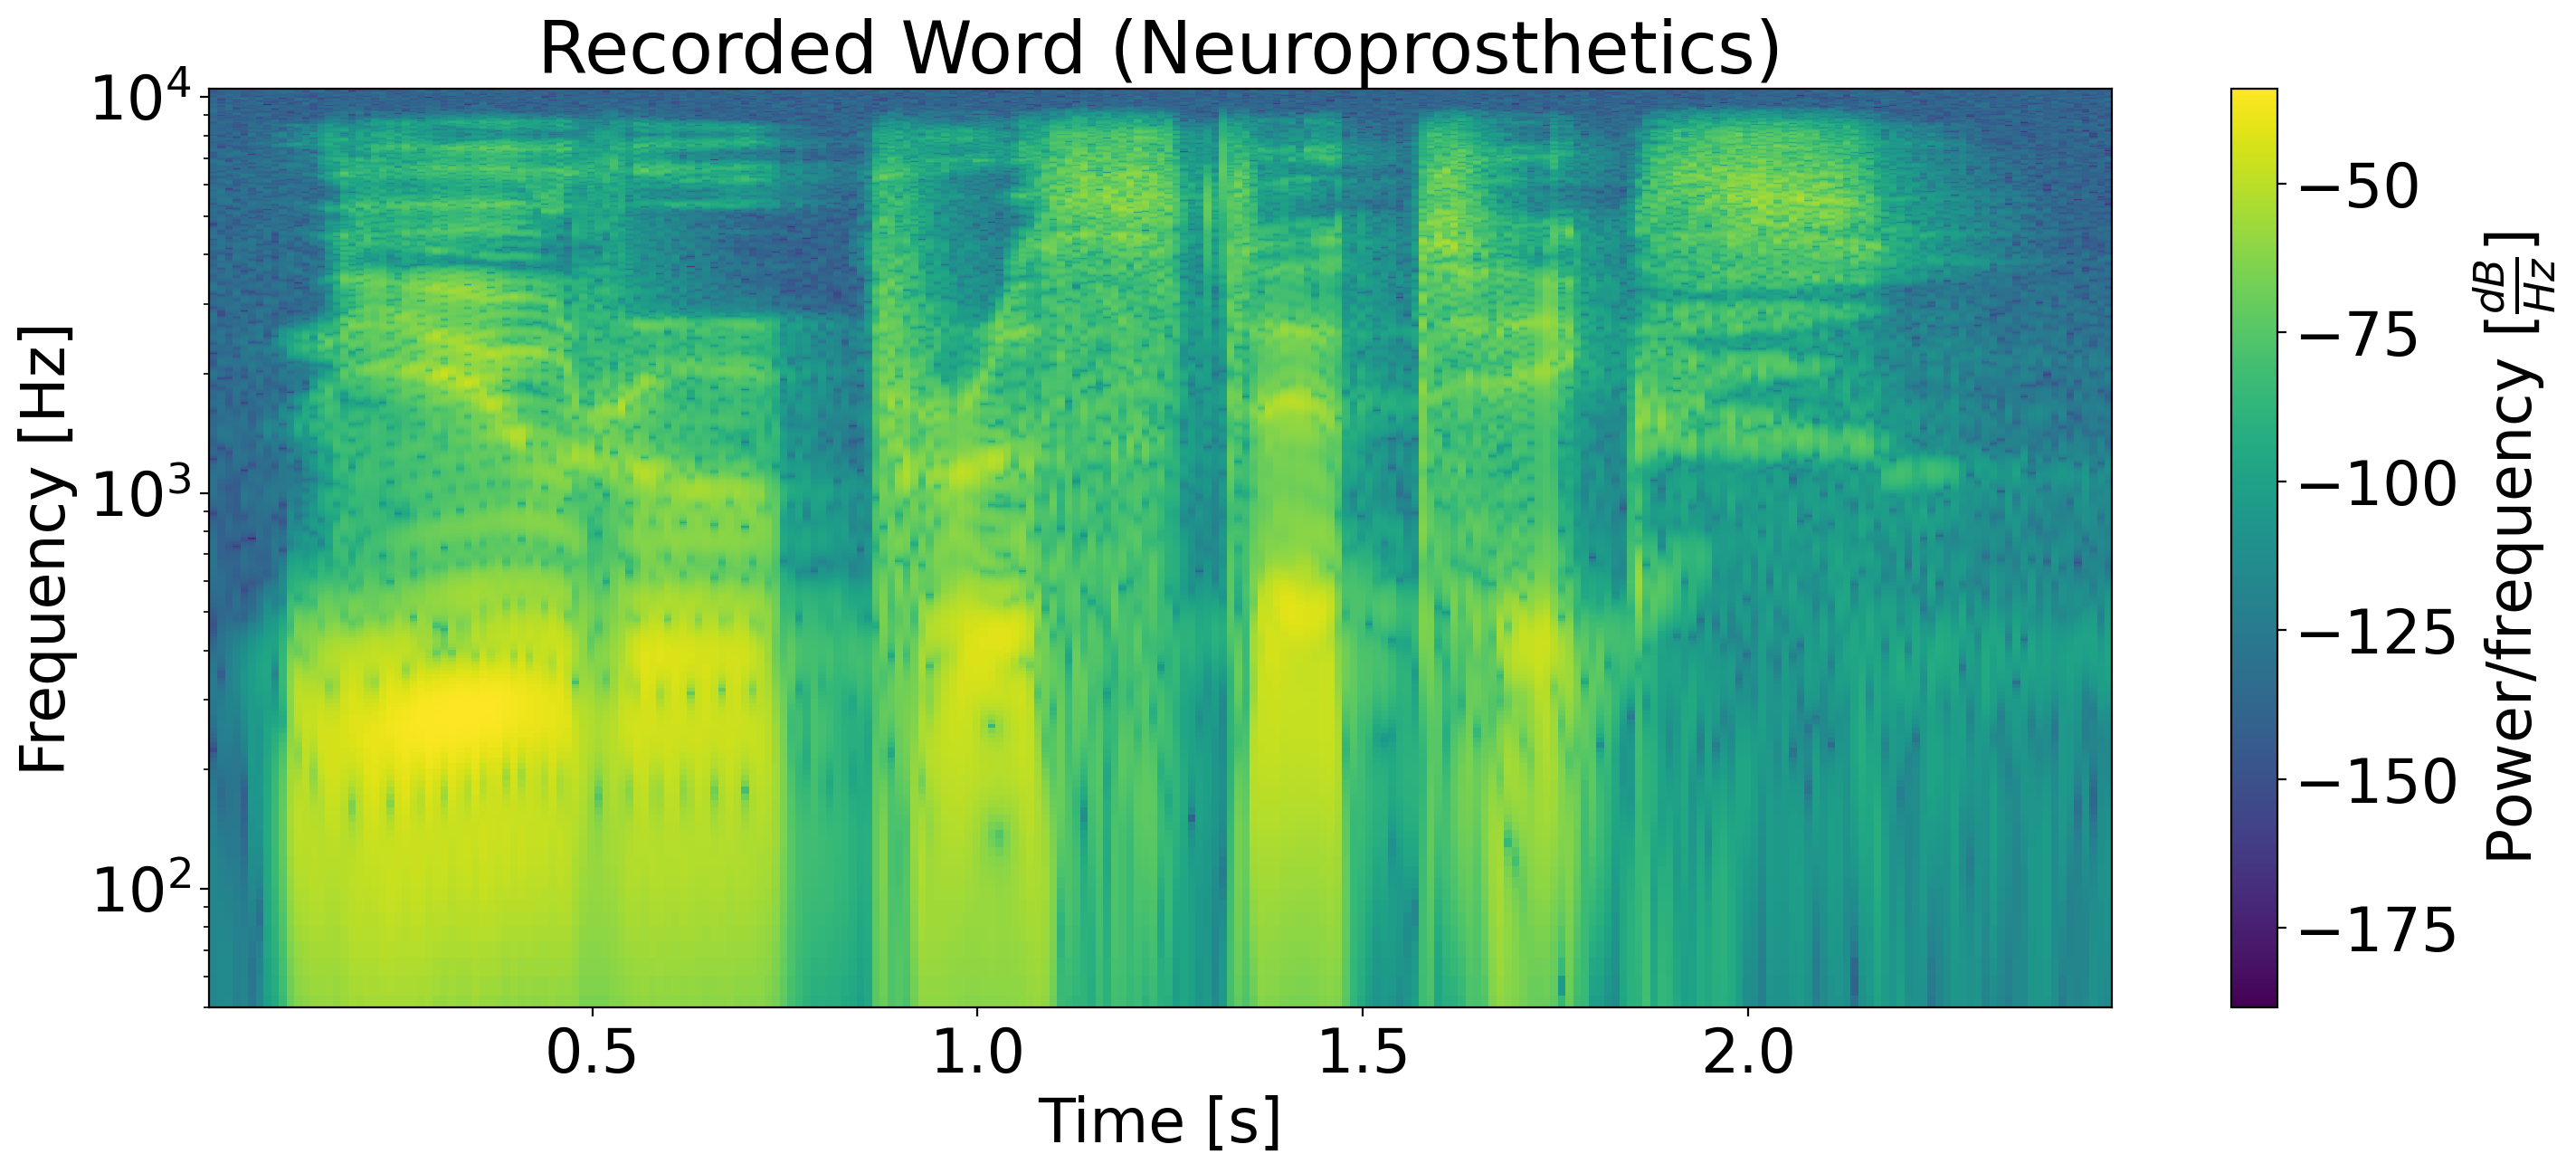

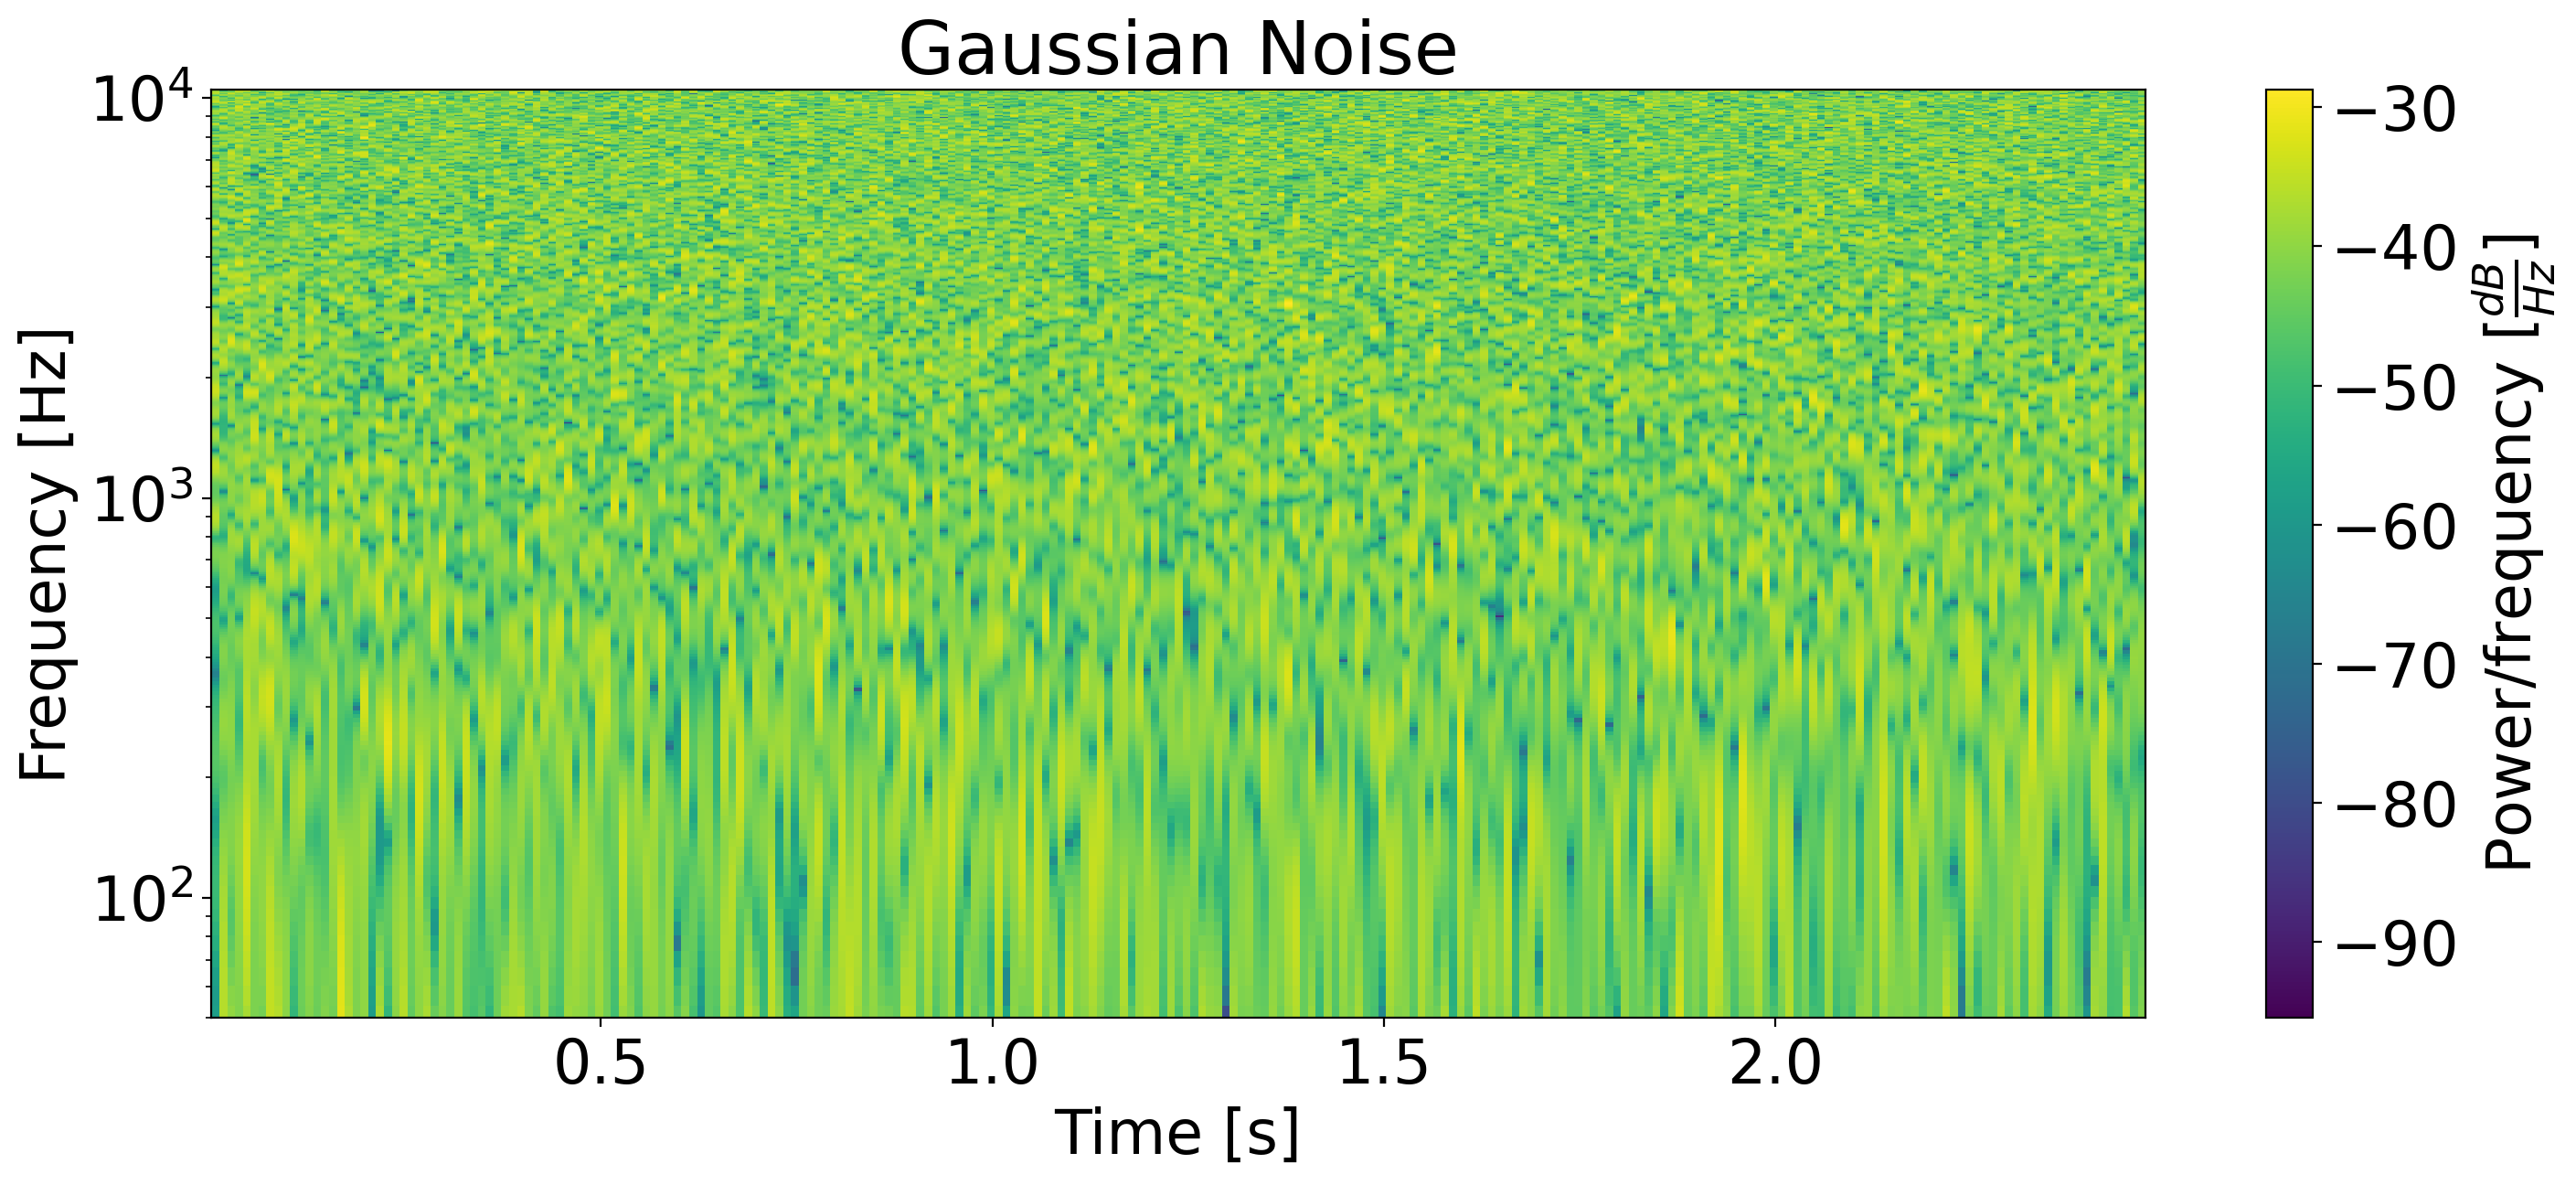

In [7]:
def plot_specto(sound,name):
    plt.figure()
    overlap= round(5e-3*sr1)
    nfft=round(15e-3*sr1)
    plt.specgram(sound, pad_to=nfft*10, NFFT=nfft, noverlap=overlap, Fs=sr1, cmap='viridis',scale="dB")
    plt.yscale("log")
    plt.ylim(5e1, sr1/2)
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')
    cbar = plt.colorbar()
    cbar.set_label('Power/frequency [$\\frac{dB}{Hz}$]')
    plt.title(name)
    plt.tight_layout()
    plt.savefig(f"spectrograms_{name}.pdf")
    plt.show
plot_specto(sound1,"Recorded Word (Neuroprosthetics)")
plot_specto(noise,"Gaussian Noise")

<function matplotlib.pyplot.show(close=None, block=None)>

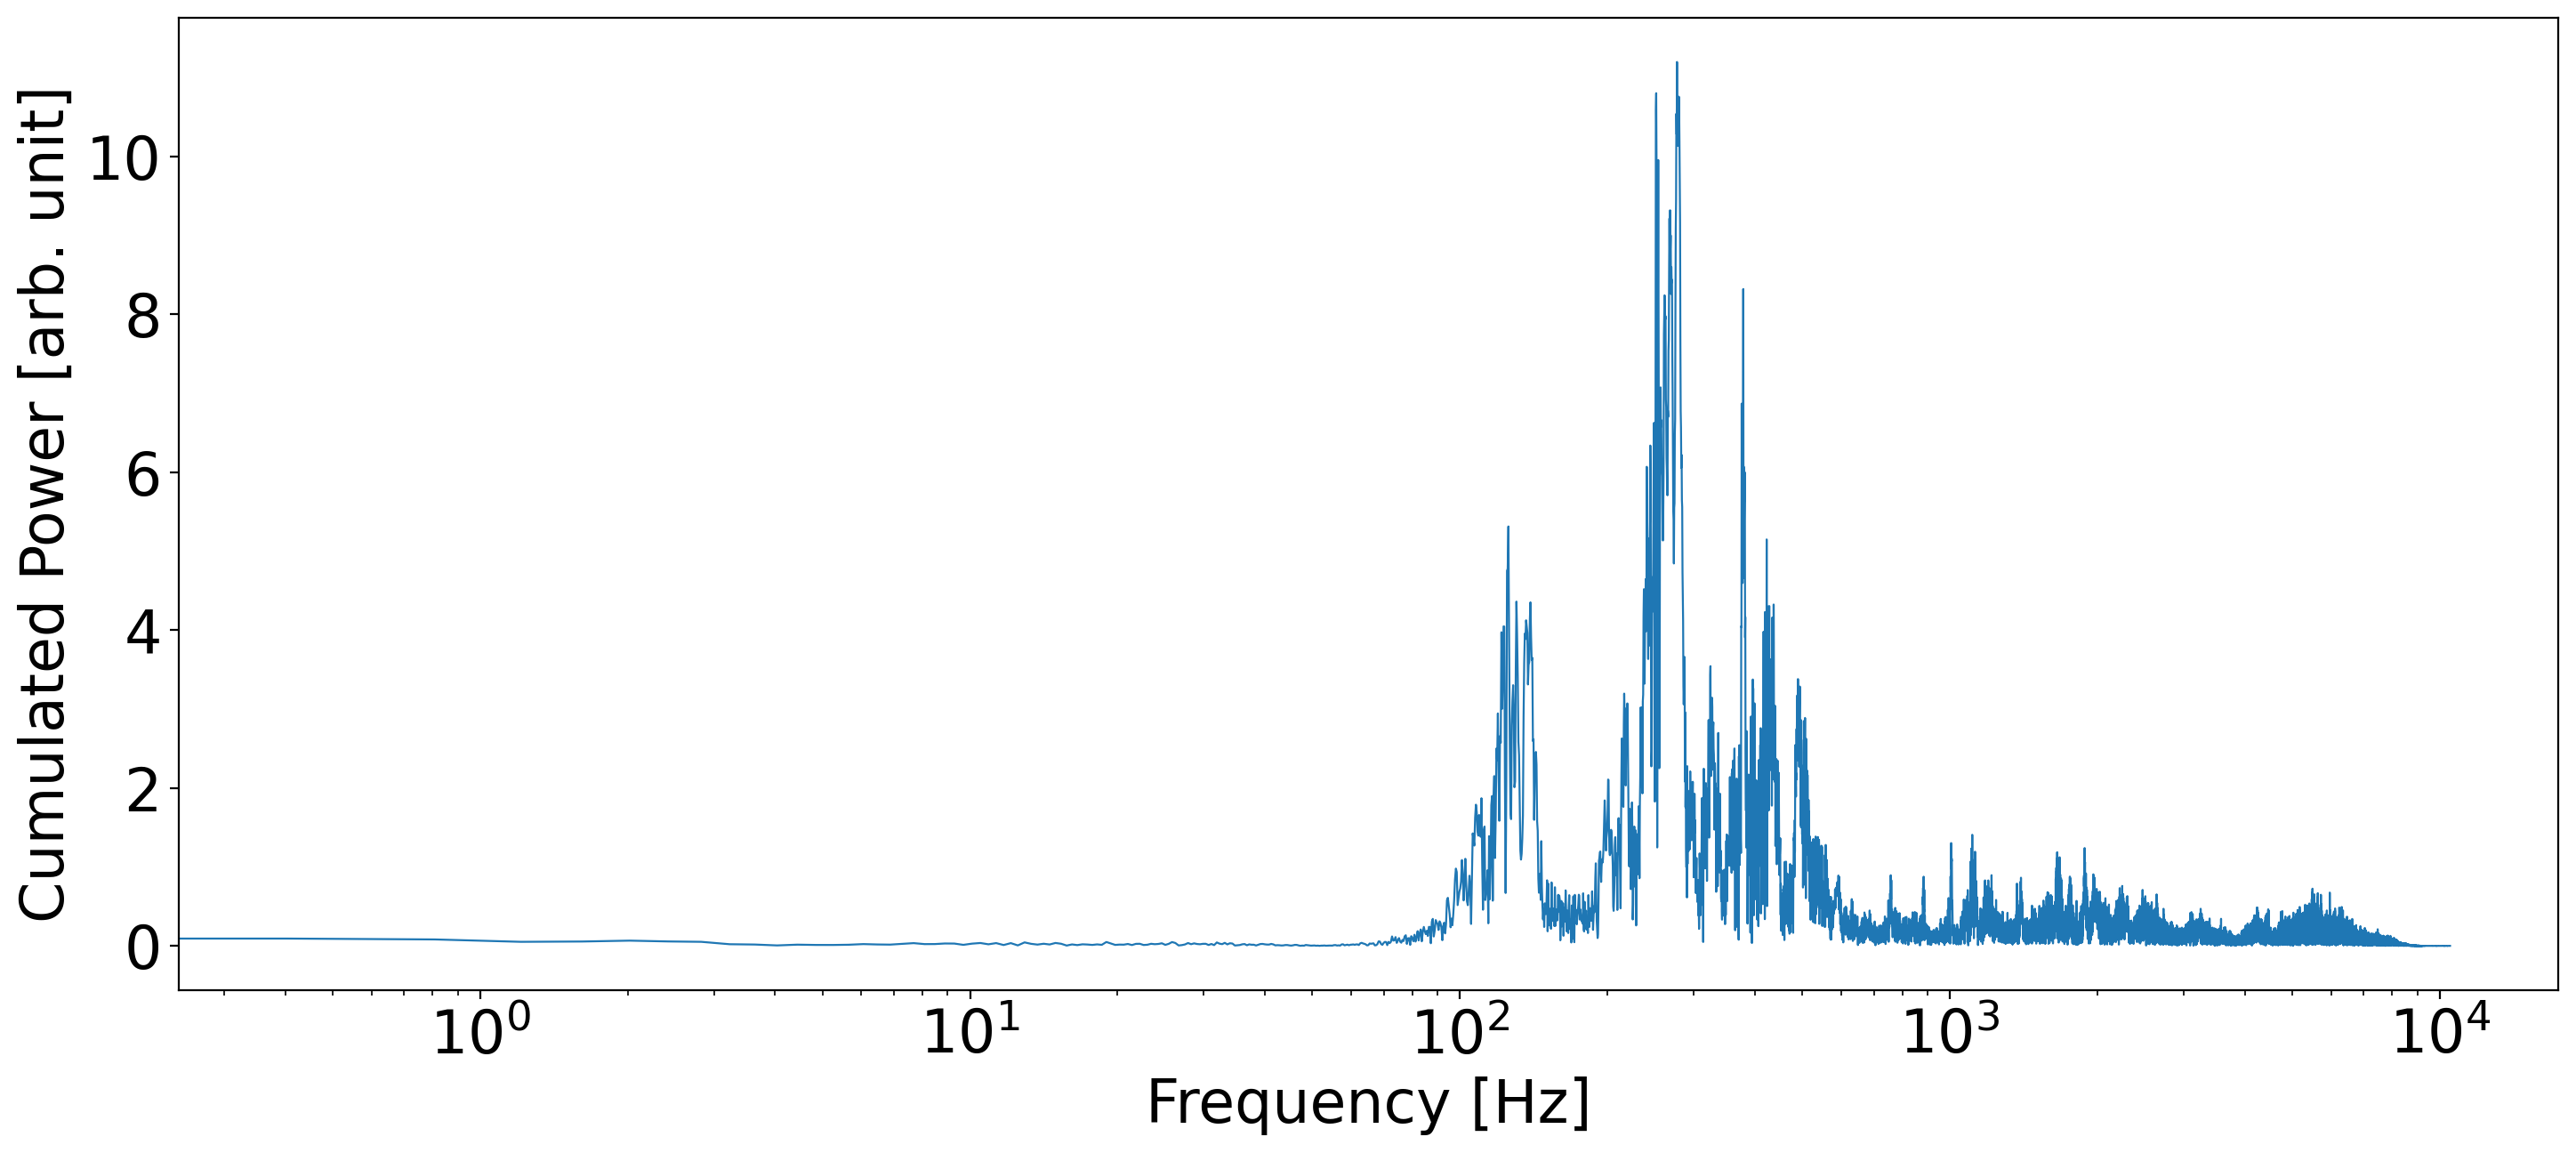

In [8]:
def FFT(f_time, sampling_rate):

    F_fft = np.fft.rfft(f_time, norm="forward")
    F_amp = np.abs(F_fft)*2
    F_amp[0] = F_amp[0]/2
    freqs = np.fft.rfftfreq(len(f_time), 1/sampling_rate)
    t1 = np.arange(0, 1, 1/sampling_rate)

    return [F_amp, freqs]

F1, freqs1 = FFT(sound1,sr1)
def smoothen(Function, window):
    logwind_f = np.logspace(np.log10(0.1*window), np.log10(np.max(freqs1)*window), len(Function))
    logwind = [int(x) for x in logwind_f]
    smoothed = np.zeros(len(Function))
    for idx, i in enumerate(Function):
        if (idx - logwind[idx]) < 0:
            smoothed[idx] = 0
        elif idx > len(Function)-logwind[idx]:
            smoothed[idx] = 0
        else:
            smoothed[idx] = sum(Function[idx - logwind[idx]:idx + logwind[idx] + 1]) / (2 * logwind[idx])


    return smoothed
            
#F1_smooth= np.array(smoothen(F1,500))
plt.semilogx(freqs1,F1*1e3)
#plt.semilogx(freqs1,F1_smooth*1e3,label="smoothend")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Cumulated Power [arb. unit]")
plt.tight_layout()
#plt.legend()
plt.savefig("Spectrum.pdf")
plt.show

[ 100.          154.99189875  240.2248868   372.32911333  577.07996236
  894.427191   1386.28968631 2148.63670705 3330.21282961 5161.56009719
 8000.        ]


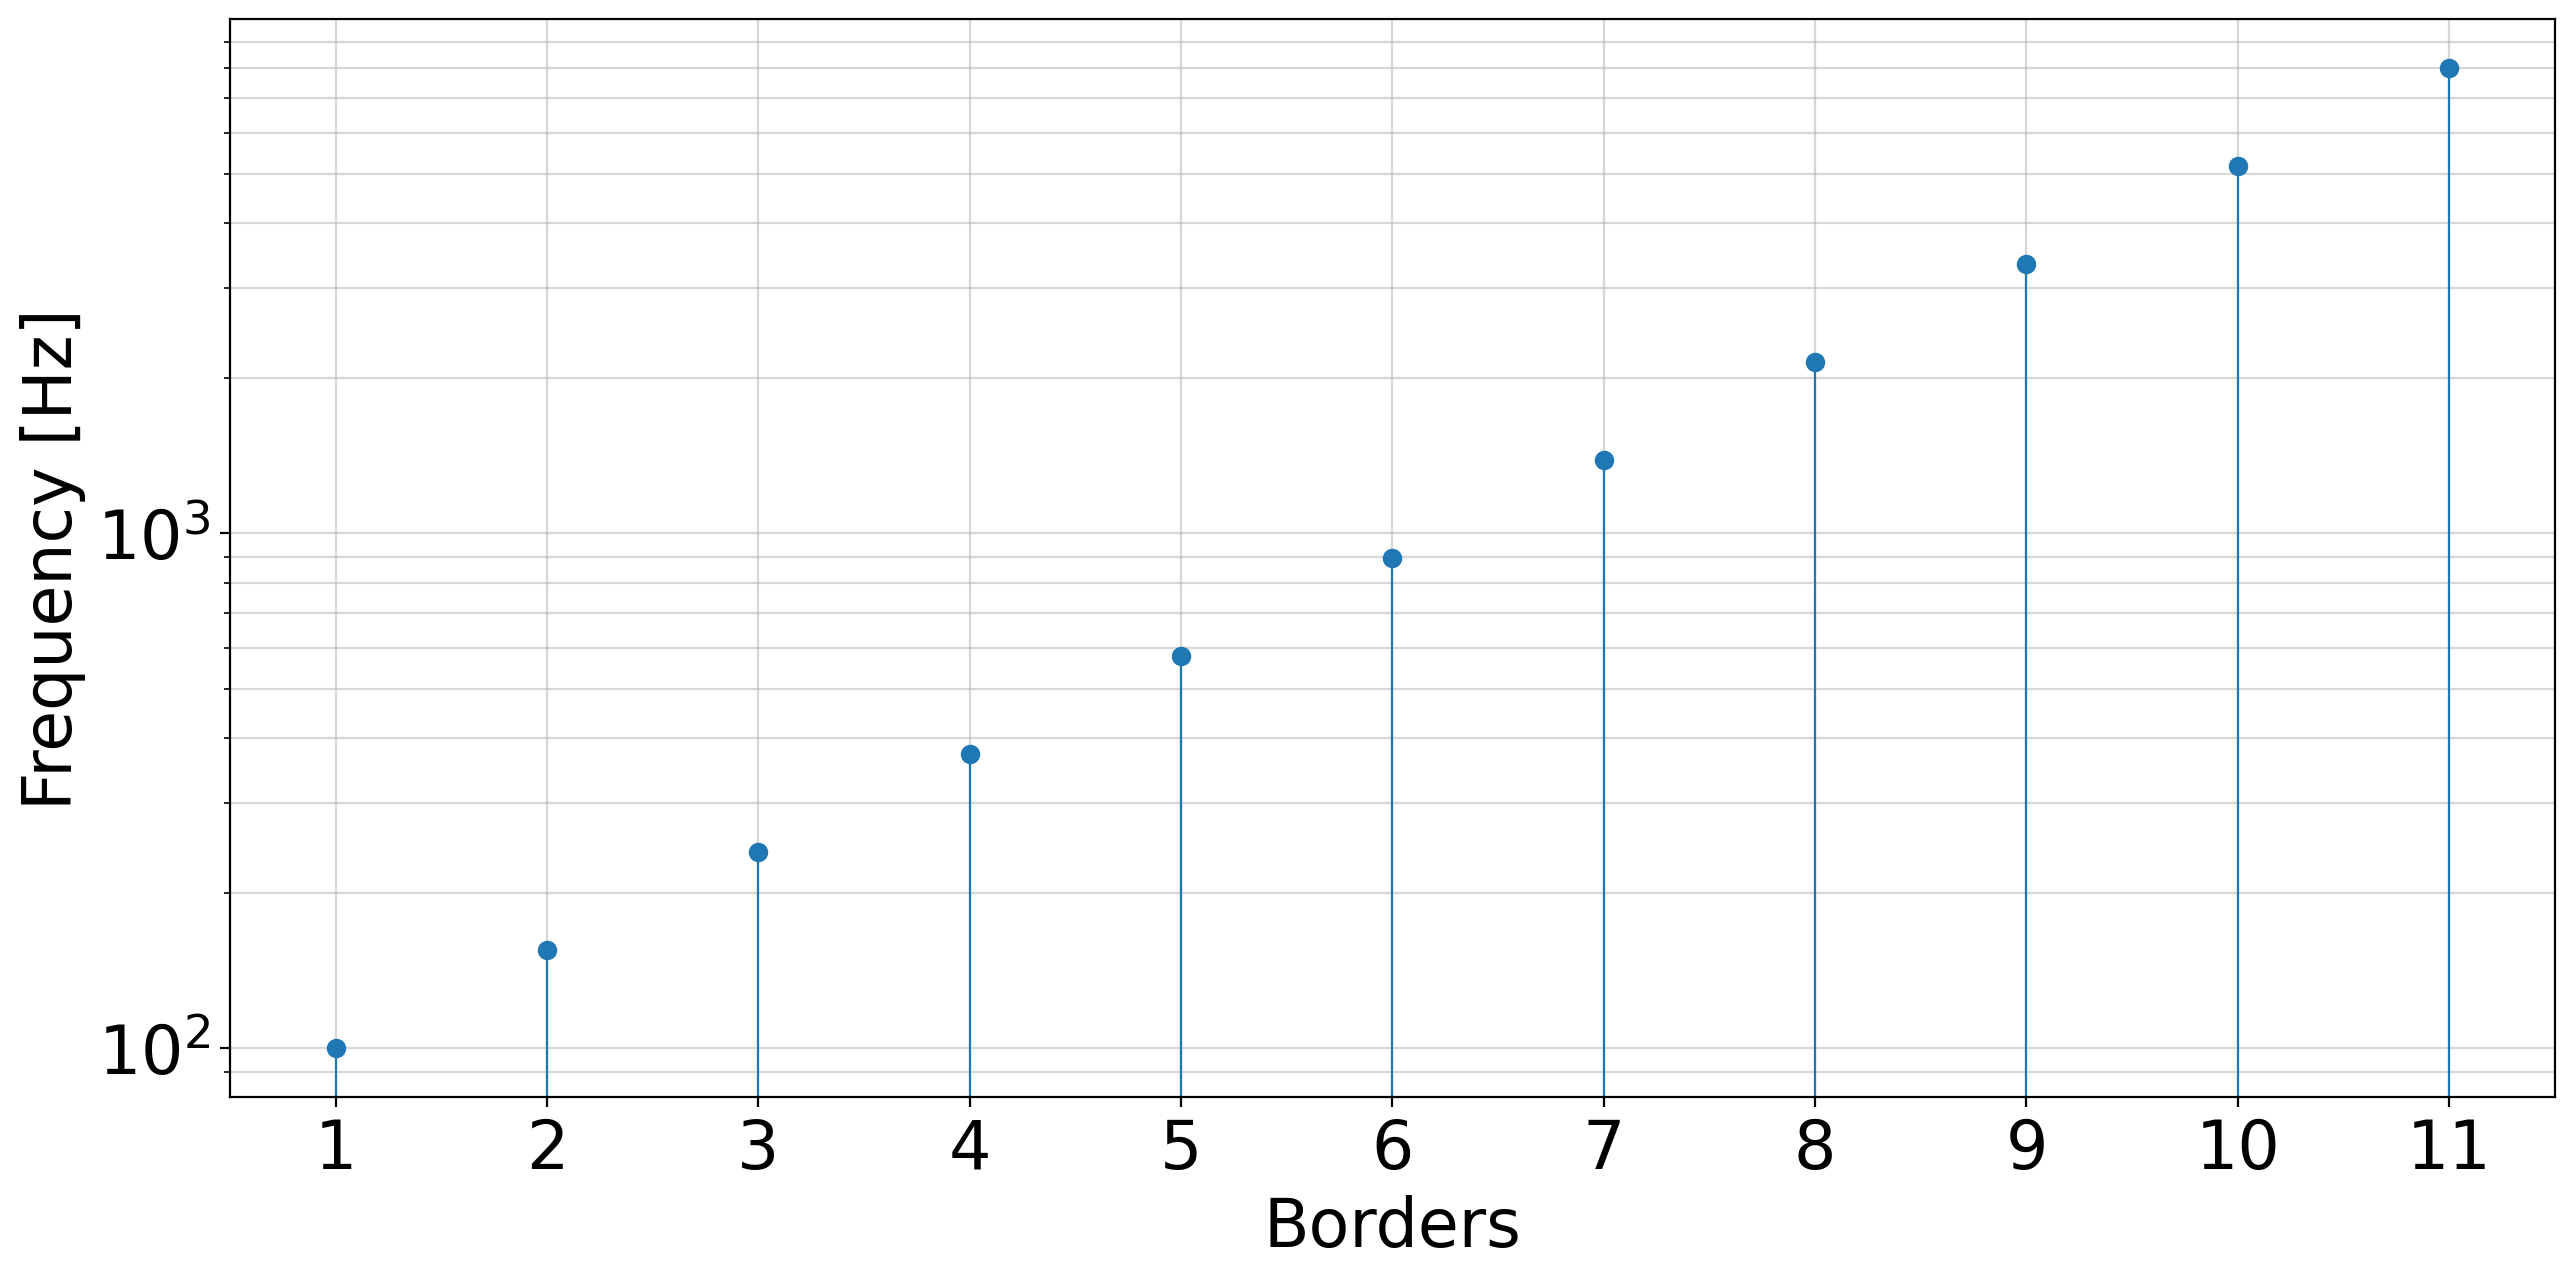

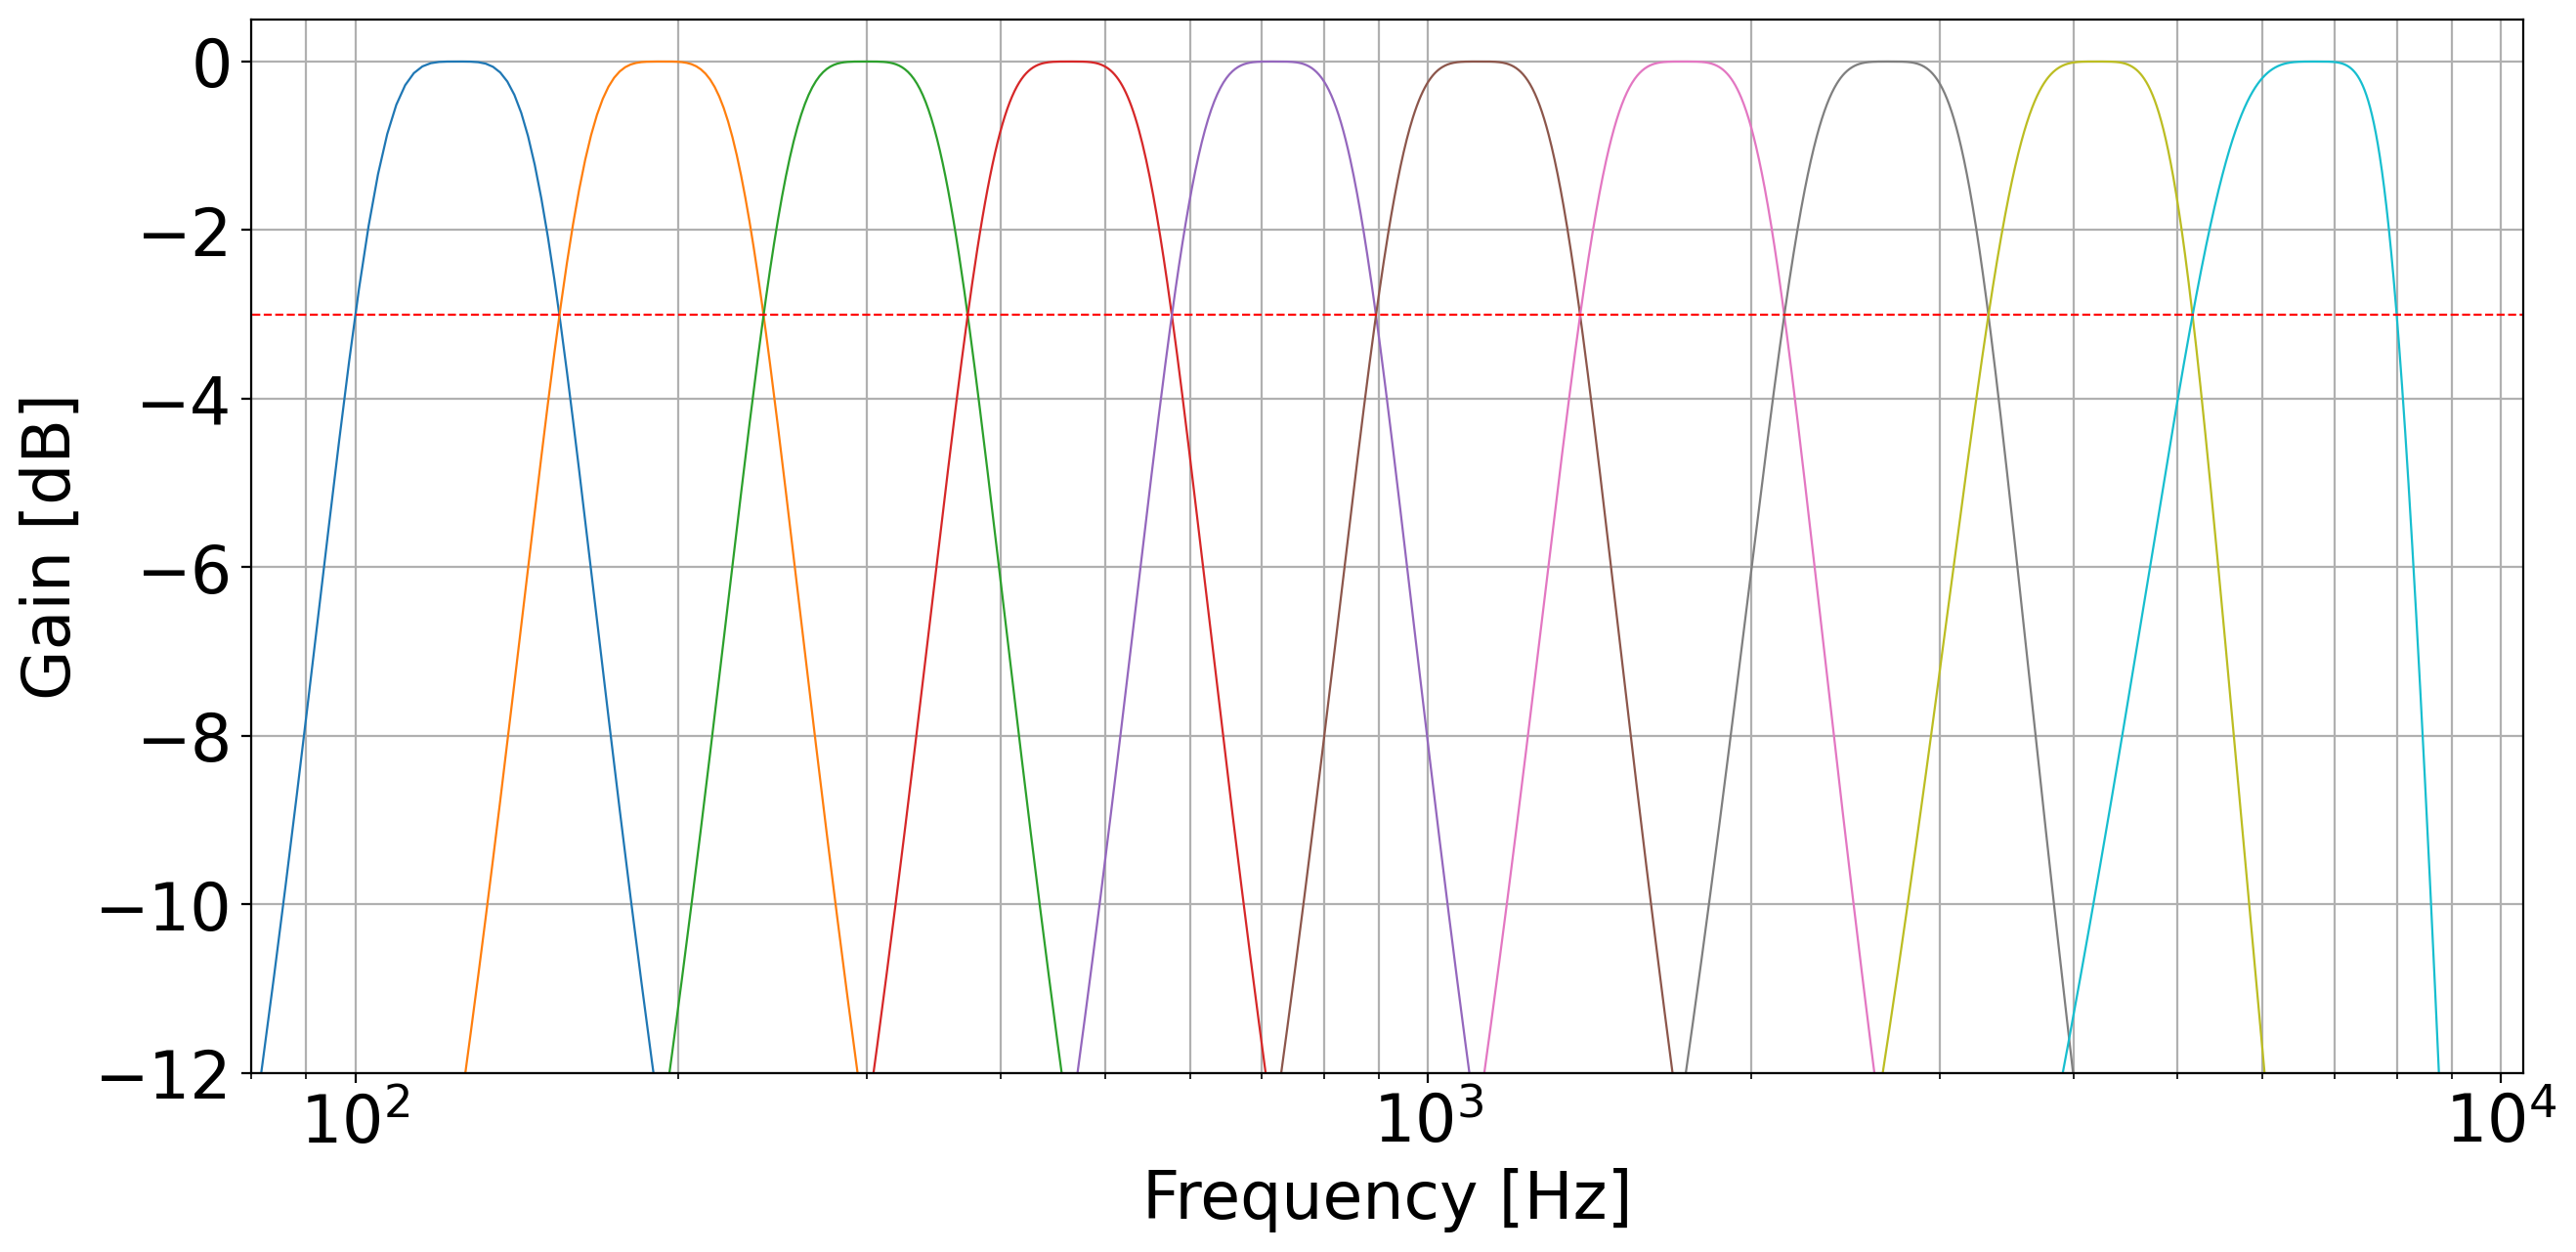

(10, 52000)


In [9]:
channels = 10
f_low = 100
f_high = 8000

f_borders = np.logspace(np.log10(f_low), np.log10(f_high), channels + 1)
print(f_borders)

plt.stem(np.arange(1,channels+2),f_borders)
plt.yscale("log")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Borders")
plt.xticks(np.arange(1,12))
plt.grid(True, which='both',alpha=0.5)
plt.show()

order=2

def filterbank_voice_noise(voice,noise):
    voice_f=[]
    noise_f=[]
    for f_c in range(channels):
        Wn = [f_borders[f_c] / (sr1 / 2), f_borders[f_c + 1] / (sr1 / 2)]
        b, a = butter(order, Wn, btype='band', analog=False, output='ba')
        w, h = freqz(b, a, fs=sr1, worN=5000)
        voice_f.append(signal.filtfilt(b, a, voice))
        noise_f.append(signal.filtfilt(b, a, noise))
        plt.semilogx(w,  20 * np.log10(np.abs(h)+1e-16))
    plt.plot([8e-1, sr1 / 2],[-3,-3],c="r",linestyle="--")
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Gain [dB]')
    plt.grid(which='both', axis='both')
    plt.ylim(-12, 0.5)
    plt.xlim(80, sr1 / 2)
    plt.savefig("filterbank.pdf")
    plt.show()
    return np.array(voice_f), np.array(noise_f)
    
voice_f, noise_f = filterbank_voice_noise(sound1,noise)
print(voice_f.shape)


In [10]:
# hilbert:
def get_envs (signals):
    envs = []
    for idx, i in enumerate(signals):
        envs.append(np.abs(hilbert(signals[idx])))
    print(np.array(envs).shape)
    print(envs)
    return envs
envs = get_envs(voice_f)

# COMPRESS VIA EQUATION:
def compress (signals):
    envs_comp = []
    for idx, i in enumerate(signals):
        env_comp=[]
        for s in i:
            env_comp.append(np.log10(1+300*s)/np.log10(1+300))
        envs_comp.append(env_comp)
    return envs_comp
envs_comp = compress(envs)
# for idx, i in enumerate(envs_comp):
#     plt.figure()
#     plt.plot(t,i)
#     plt.plot(t,envs[idx])
#     plt.title(idx)

(10, 52000)
[array([6.77529311e-06, 4.80432298e-06, 4.63783078e-06, ...,
       2.69618206e-06, 2.51736365e-06, 5.27939820e-06]), array([4.89448417e-06, 3.58607880e-06, 3.51353239e-06, ...,
       2.23305926e-06, 2.11742960e-06, 3.88710405e-06]), array([5.37688380e-06, 5.26179517e-06, 5.09941327e-06, ...,
       7.20599988e-06, 6.58664246e-06, 5.74285217e-06]), array([1.15971511e-05, 5.80357166e-06, 4.88355428e-06, ...,
       9.41995000e-06, 8.26510522e-06, 1.24171382e-05]), array([3.58920748e-06, 5.07447369e-06, 5.63578491e-06, ...,
       2.27493112e-06, 2.21729727e-06, 2.33571555e-06]), array([1.14828628e-05, 1.11812830e-05, 1.14096670e-05, ...,
       1.07322189e-05, 1.02275474e-05, 1.09266710e-05]), array([3.89476320e-06, 3.06585765e-06, 3.39911483e-06, ...,
       4.80667481e-06, 3.98503020e-06, 4.34811464e-06]), array([9.93590710e-06, 1.85348710e-05, 2.07334329e-05, ...,
       3.02103816e-06, 2.87228068e-06, 1.76405139e-06]), array([4.64541403e-06, 9.10196696e-06, 9.41487532e-

FileNotFoundError: [WinError 2] Das System kann die angegebene Datei nicht finden

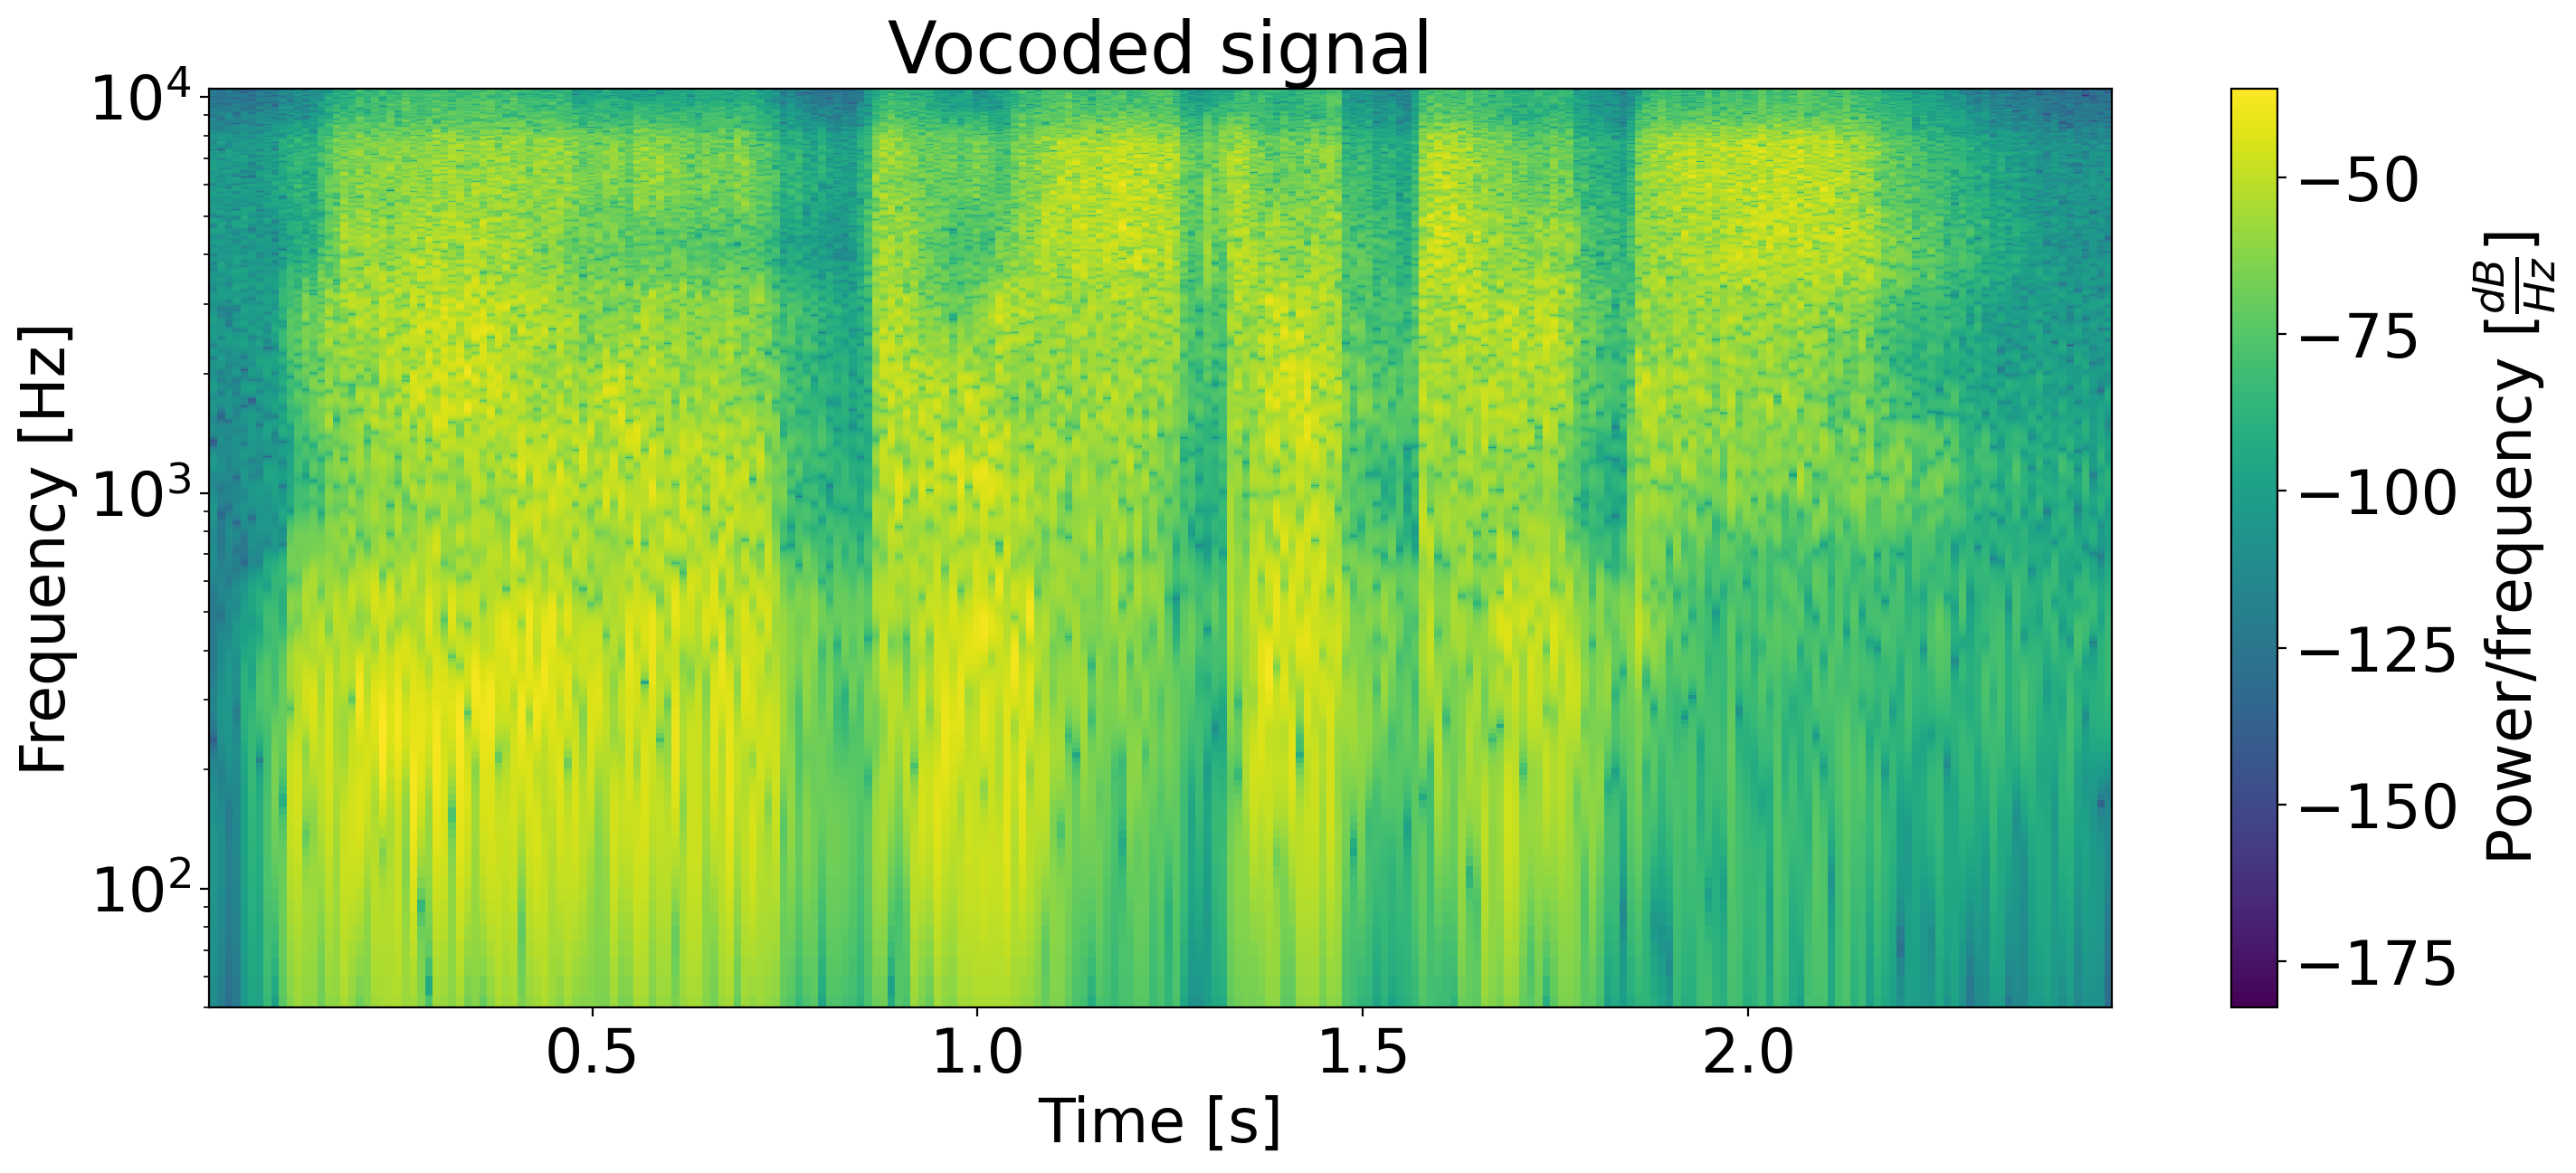

In [11]:
def modulate(envelops, noise):
    signals_voc=[]
    for idx, e in enumerate(envelops):
        signal_voc=[]
        for idx2, i in enumerate(e):
            signal_voc.append(i*noise[idx][idx2])
        signals_voc.append(signal_voc)
      
    vocoded_sum = np.sum(signals_voc, axis=0)
        
    return np.array(signals_voc), vocoded_sum
signals_voc, vocoded_sum = modulate(envs_comp,noise_f)
#play_sound(signals_voc[9])
play_sound(vocoded_sum,"final")
# for idx, i in enumerate(signals_voc):
#     plt.figure()
#     plt.plot(t,i)
#     plt.title(idx)
plot_specto(vocoded_sum,"Vocoded signal")
def wav_to_mp3(input_file, output_file, bitrate="192k"):
    audio = AudioSegment.from_wav(input_file)

    audio.export(output_file, format="mp3", bitrate=bitrate)
wav_to_mp3("Vocoder_final.wav", "Vocoder_final.mp3")
wav_to_mp3("sound.wav", "sound.mp3")

In [ ]:
play_sound(voice_f[1])
play_sound(voice_f[8])


plot_specto(voice_f[1],"Filtered voice (Channel 2)")
plot_specto(voice_f[8],"Filtered voice (Channel 9)")
plot_specto(noise_f[1],"Filtered noise (Channel 2)")
plot_specto(noise_f[8],"Filtered noise (Channel 9)")